# Accuracy of the Comparison Model as Prediction
Given a game with **12**-month data. Here we build our Time Comparison Model to observe how games with similar **12**-month history behave in the next **6**-month and check its accuracy as prediction with our test set. Parameters are chosen based on Cross Validation computed in the TS_ModelExp notebook. For more explanations on the algorithm, please refer to the TS_ModelExp notebook as well.

In [1]:
import pandas as pd
import numpy as np

#For plotting
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.base import clone

# Import the SimpleExpSmoothing object
from statsmodels.tsa.api import SimpleExpSmoothing

### Load in the training and test data from the DataPreparation notebook

In [2]:
train = pd.read_csv('Training_data.csv', index_col=0)
train_pure = train.drop(columns=['App_id', 'Name', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days', 'max', 'birth']).astype(float)
test = pd.read_csv('Test_data.csv', index_col = 0)
test_pure = test.drop(columns=['App_id', 'Name', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days', 'max', 'birth']).astype(float)

In [3]:
# Making a list of first 12 month data
def nonsmooth_values(data):
    nonsmooth = []
    for i in range(len(data)):
        game_data = data.iloc[i]
        months = pd.to_datetime(game_data.index)
        game = pd.DataFrame({'Month':months,'Data': game_data.astype(float)}).sort_values(by=['Month'])
        temp = game['Data'][game['Data'].first_valid_index():game['Data'].last_valid_index()].values
        nonsmooth.append(temp)
    return nonsmooth

In [4]:
nonsmooth_test = nonsmooth_values(test_pure)
nonsmooth_train = nonsmooth_values(train_pure)

# Time Comparison Model

Define the metric and weight using l2 norm and Gaussian kernel.

In [5]:
def rootmse(a, b):
    return np.sqrt(np.sum((a-b)**2))

def Gauss_weight(a, b, epsilon = 20):
    return np.exp(-epsilon*rootmse(a,b)**2)

To compare the shape of 2 curves, we want to compute the scalar that makes 2 curves close together by scaling only.

In [6]:
def mini_scaler(a,b):
    return np.sum(a*b)/np.sum(a**2)

Exponential Smoothing with smoothing level = .6

In [7]:
# Getting the smoothed curve for each game
# Ordered in increasing time order.

def smooth_values(data, smoothing_level=.6):
    smooth_timedata = []
    for i in range(len(data)):
        game_data = data.iloc[i]
        months = pd.to_datetime(game_data.index)
        game = pd.DataFrame({'Month':months,'Data': game_data.astype(float)}).sort_values(by=['Month'])
        temp = game['Data'][game['Data'].first_valid_index():game['Data'].last_valid_index()]
    
        # Fit exponential smoothing
        ses = SimpleExpSmoothing(temp.values)
        fit = ses.fit(smoothing_level=smoothing_level, optimized=False)

        smooth_timedata.append(fit.fittedvalues)
        
    return smooth_timedata

Main Algorithm

In [8]:
def wt_avg(game, smooth_game, data, smooth_data, metric = Gauss_weight, epsilon = 20, threshold=0.8, horizon = 6):
    length = len(game)
    smooth_length = len(smooth_game)
    if np.max(np.abs(smooth_game))!=0:
        smooth_game_scaled = smooth_game / rootmse(smooth_game,0)
    else:
        smooth_game_scaled = smooth_game
    pred = np.zeros(length+horizon)
    close_index = np.zeros((len(data),2))
    j=0
    for i in range(len(data)):
        temp = data[i]
        smooth_temp = smooth_data[i]
        if len(temp)>=length+horizon:
            if np.max(np.abs(temp[:length]))!=0:
                temp_scaled = temp * mini_scaler(temp[:length],game)
            else: temp_scaled = temp
            if np.max(np.abs(smooth_temp[:smooth_length]))!=0:
                smooth_temp_scaled = smooth_temp * mini_scaler(smooth_temp[:smooth_length],smooth_game_scaled)
            else: smooth_temp_scaled = smooth_temp
            weight=metric(smooth_game_scaled,smooth_temp_scaled[:smooth_length], epsilon = epsilon)
            if weight >= threshold:
                pred = pred + weight * temp_scaled[:length+horizon]
                close_index[j]=[i,weight]
                j=j+1
    if np.max(np.abs(pred[:length])) !=0:
        pred = pred * mini_scaler(pred[:length],game)
    else:
        pred = np.ones(length + horizon) * smooth_game[-1]
    close_index = close_index[:j]
    close_index = close_index[np.argsort(close_index[:, 1])][::-1]
    return pred, close_index

Function for Percentage Error:

In [9]:
def get_error(train, smooth_train, test, smooth_test, threshold = 0.8, epsilon = 20):
    error = 0
    for i in range(len(test)):
        [pred, close_index] = wt_avg(test[i][:12], smooth_test[i][:12], train, smooth_train, threshold = threshold, epsilon = epsilon, horizon = 6)
        error = error + rootmse(pred[12:],test[i][12:18]) / rootmse(test[i][12:18],0)
    error = error / len(test) * 100
    return error

Getting the smoothed curves.

In [10]:
ExpSmooth_train = smooth_values(train_pure)
ExpSmooth_test = smooth_values(test_pure)

C:\Users\Joseph Leung\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


## Accuracy
Now we compute the accuracy of prediction on the test set.

In [11]:
for epsilon in [20]:
    error = get_error(nonsmooth_train, ExpSmooth_train, nonsmooth_test, ExpSmooth_test, threshold = 0.8, epsilon = epsilon)

    print('The average percentage error on the prediction of test set is ' + str(error) + '%.')

The average percentage error on the prediction of test set is 82.23114168674334%.


# A Prediction Example:

In [16]:
# Randomly pick a game from test set and use its first 18 month data
ind = 3
real_game = nonsmooth_test[ind][:18]
game = nonsmooth_test[ind][:12]
smooth_real_game = ExpSmooth_test[ind][:18]
smooth_game = smooth_real_game[:12]
[pred,close_index] = wt_avg(game, smooth_game, nonsmooth_train, ExpSmooth_train, horizon = 6, epsilon = 50, threshold = 0.8)

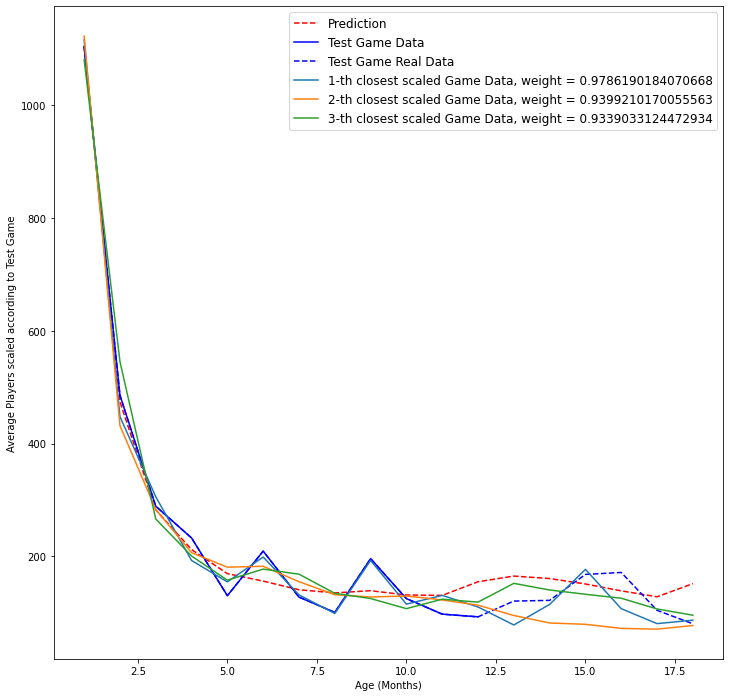

In [17]:
plt.figure(figsize=(12,12))
plt.plot(range(1,len(game)+7), pred, 'r--', label = 'Prediction')
plt.plot(range(1,len(game)+1), game, 'b', label = 'Test Game Data')
plt.plot(range(1,len(game)+7), real_game, 'b--', label = 'Test Game Real Data')

if len(close_index)>=3:
    test_range = range(3)
    for i in test_range:
        close_game = nonsmooth_train[int(close_index[i][0])][:len(game)+6]
        scaled_close_game = close_game * mini_scaler(close_game[:len(game)],game)
        plt.plot(range(1,len(game)+7), scaled_close_game, label = str(i+1)+'-th closest scaled Game Data, weight = ' + str(close_index[i][1]))

plt.legend(fontsize=12)
plt.xlabel('Age (Months)')
plt.ylabel('Average Players scaled according to Test Game')
plt.show()